In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import numpy as np

from torch.utils.data import DataLoader,random_split

In [2]:
# load dataset by using torchvision
transform = torchvision.transforms.Compose([
    # resize to 128x128
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.ToTensor()
])
# target_transform -> one-hot encoding
target_transform = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda y: torch.zeros(7, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
])
dataset = torchvision.datasets.ImageFolder(root='../../data/extracted', transform=transform, target_transform=target_transform)

In [3]:
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [4]:
for x, y in data_loader:
    print(x.shape, y.shape)
    print(y)
    break

torch.Size([4, 3, 128, 128]) torch.Size([4, 7])
tensor([[0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.]])


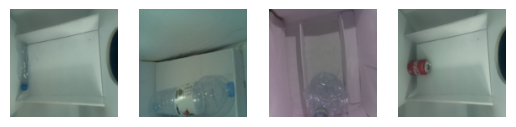

In [5]:
# plot few images
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(x[i].permute(1, 2, 0))
    ax[i].axis('off')
plt.show()

In [6]:
# define model
class VanillaCNN(nn.Module):
    def __init__(self):
        super(VanillaCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(32768, 1024)
        self.fc2 = nn.Linear(1024, 7)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
from torchvision.models import resnet50,efficientnet_v2_s

class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        self.resnet = resnet50()
        self.resnet.fc = nn.Linear(2048, 7)

    def forward(self, x):
        return self.resnet(x)
    
class EfficientNetV2S(nn.Module):
    def __init__(self):
        super(EfficientNetV2S, self).__init__()
        self.efficientnet = efficientnet_v2_s()
        self.efficientnet.classifier = nn.Linear(1280, 7)

    def forward(self, x):
        return self.efficientnet(x)

In [7]:
# split dataset into train and test
n = len(dataset)
n_train = int(0.8*n)
n_test = n - n_train
train_dataset, test_dataset = random_split(dataset, [n_train, n_test])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [8]:
# test forward pass
model = EfficientNetV2S()
for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    pred = model(x)
    print(pred.shape)
    print(torch.argmax(pred, 1))
    print(torch.argmax(y, 1))
    correct = (torch.argmax(pred, 1) == torch.argmax(y,1)).sum().item()
    print(correct)
    break


torch.Size([32, 3, 128, 128])
torch.Size([32, 7])
torch.Size([32, 7])
tensor([3, 3, 3, 3, 1, 6, 3, 5, 3, 1, 6, 3, 2, 5, 3, 3, 1, 6, 2, 5, 1, 1, 1, 1,
        6, 6, 0, 6, 6, 0, 1, 3])
tensor([5, 1, 5, 1, 1, 5, 4, 5, 4, 5, 1, 6, 5, 1, 1, 5, 4, 1, 1, 0, 1, 1, 6, 2,
        4, 1, 5, 1, 1, 5, 4, 5])
4


In [9]:
for x,y in test_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 128, 128])
torch.Size([32, 7])


In [10]:
# training

# define device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

# define model
model = EfficientNetV2S().to(device)

# define loss function
criterion = nn.BCEWithLogitsLoss()

# define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

# training recrod
train_loss = []
train_acc = []
test_loss = []
test_acc = []
confidence = {}

# training loop
n_epoch = 10
cnt = 0

for epoch in range(n_epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = torch.argmax(y_pred, 1)
        total += y.size(0)
        correct += (predicted == torch.argmax(y,1)).sum().item()
    train_loss.append(running_loss/total)
    train_acc.append(correct/total)
    print(f'epoch: {epoch+1}, train loss: {train_loss[-1]}, train acc: {train_acc[-1] * 100:.2f}%', end=', ')

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            running_loss += loss.item()
            predicted = torch.argmax(y_pred, 1)
            total += y.size(0)
            correct += (predicted == torch.argmax(y,1)).sum().item()
    test_loss.append(running_loss/total)
    test_acc.append(correct/total)
    print(f'test loss: {test_loss[-1]}, test acc: {test_acc[-1] * 100:.2f}%')

    # calculate confidence
    model.eval()
    confidence_list = []

    for input, target in test_loader:
        input, target = input.to(device), target.to(device)
        # 計算每個實例的預測概率
        with torch.no_grad():
            output = model(input)
            probs = F.softmax(output, dim=1)

        for i in range(len(probs)):
            confidence_list.append(probs[i][torch.argmax(target[i])].item())

    confidence[epoch] = confidence_list

device: cuda
epoch: 1, train loss: 0.013475506279234575, train acc: 42.17%, test loss: 0.0115330204021099, test acc: 44.19%
epoch: 2, train loss: 0.009808857759861189, train acc: 49.18%, test loss: 0.010473311086033665, test acc: 44.19%
epoch: 3, train loss: 0.00921030008347235, train acc: 51.99%, test loss: 0.00992766632590183, test acc: 56.28%
epoch: 4, train loss: 0.007711212612061857, train acc: 65.07%, test loss: 0.00649622637172078, test acc: 69.30%
epoch: 5, train loss: 0.006946741907953102, train acc: 70.91%, test loss: 0.008642871227375297, test acc: 67.44%
epoch: 6, train loss: 0.005949913271676714, train acc: 73.36%, test loss: 0.029114550490712012, test acc: 35.81%
epoch: 7, train loss: 0.005801854054574097, train acc: 73.95%, test loss: 0.0078025122714597125, test acc: 64.19%
epoch: 8, train loss: 0.005375232103620177, train acc: 76.29%, test loss: 0.0075813219297763915, test acc: 65.12%
epoch: 9, train loss: 0.004737555388813821, train acc: 78.39%, test loss: 0.0062702368

In [11]:
confidence_list = [[] for _ in range(len(confidence[0]))]
for epoch in confidence:
    for i in range(len(confidence[epoch])):
        confidence_list[i].append(confidence[epoch][i])

confidence_list = np.array(confidence_list)
confidence_list.shape

(215, 10)

In [12]:
mean = np.mean(confidence_list, axis=1)
std = np.std(confidence_list, axis=1)
variability = std / mean

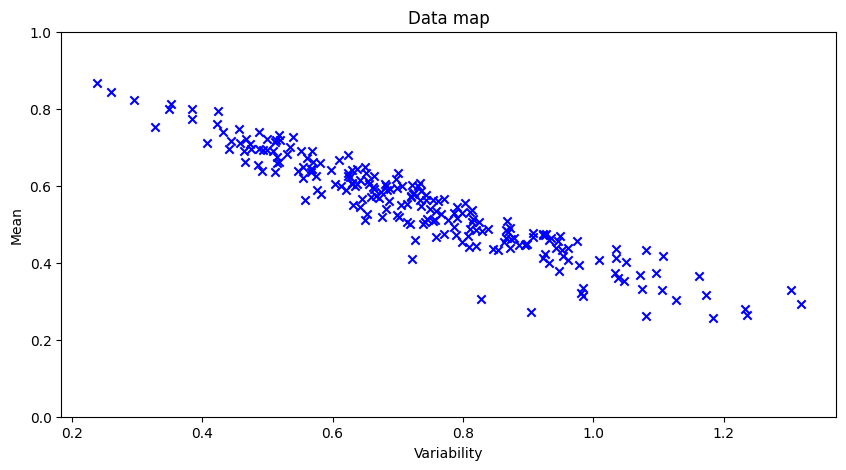

In [13]:
# plot mean and variability (dot plot)

plt.figure(figsize=(10, 5))
plt.scatter(variability, mean, c='b', marker='x')
plt.xlabel('Variability')
plt.ylabel('Mean')
plt.ylim(0, 1)
plt.title('Data map')
plt.show()